# Aluno: Lucas de Moura Santos

### Cálculo: Equalização de Histograma

In [6]:
import numpy as np
import glob
from skimage.io import imread
from skimage import data
from skimage.exposure import histogram
from scipy.stats import skew, kurtosis
from skimage.measure import shannon_entropy
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
%matplotlib inline
from skimage import color, feature
import cv2
from skimage.exposure import equalize_hist

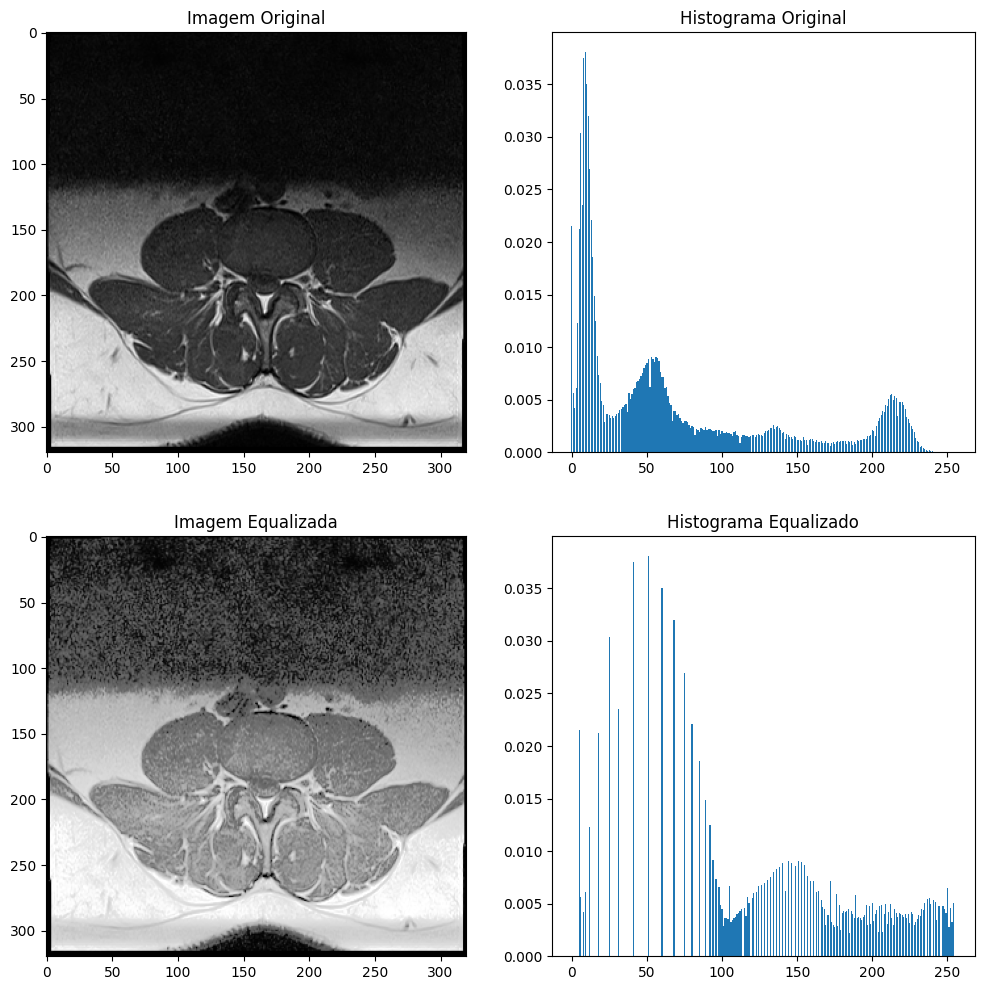

In [4]:
# Carregue a imagem em escala de cinza
image = cv2.imread('imagens/T1_0001_D3.png', cv2.IMREAD_GRAYSCALE)

def hist_eq(img):
    # Calcule o histograma da imagem original. Cria um array inicializados com o valor 0 e incrementado 1 a cada ocorrência de determinado tom de cinza.
    hist_original = np.zeros(256, dtype=int)
    for row in img:
        for pixel in row:
            hist_original[pixel] += 1

    # Normalize o histograma | Histograma Original
    total_pixels = img.shape[0] * img.shape[1] #Altura x largura da imagem
    hist_original = hist_original / total_pixels

    #  Calcula a função de distribuição acumulada (CDF). Calcula a probabilidade acumulada de encontrar um pixel com uma intensidade de cinza menor ou igual a i
    cdf = np.zeros(256, dtype=float)
    cdf[0] = hist_original[0]
    for i in range(1, 256):
        cdf[i] = cdf[i - 1] + hist_original[i]

    # Mapeie a imagem original para a imagem equalizada **np.interp**
    equalized_image = np.interp(img, np.arange(256), cdf * 255)
    equalized_image = equalized_image.astype(np.uint8) #Converte a imagem em valores inteiros de 8 bits (0 a 255)

    # Calcule o histograma da imagem equalizada
    hist_equalized = np.zeros(256, dtype=int)
    for row in equalized_image:
        for pixel in row:
            hist_equalized[pixel] += 1

    # Normalize o histograma equalizado
    hist_equalized = hist_equalized / total_pixels
    
    return [hist_original, equalized_image, hist_equalized]


# Executa a função
new_image_eq = hist_eq(image)

# Exiba a imagem original e a imagem equalizada, juntamente com seus histogramas
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.title('Imagem Original')
plt.imshow(image, cmap='gray')

plt.subplot(2, 2, 2)
plt.title('Histograma Original')
plt.bar(np.arange(256), new_image_eq[0])

plt.subplot(2, 2, 3)
plt.title('Imagem Equalizada')
plt.imshow(new_image_eq[1], cmap='gray')

plt.subplot(2, 2, 4)
plt.title('Histograma Equalizado')
plt.bar(np.arange(256), new_image_eq[2])

plt.show()

### Atributos de Textura de 1$^a$ ordem

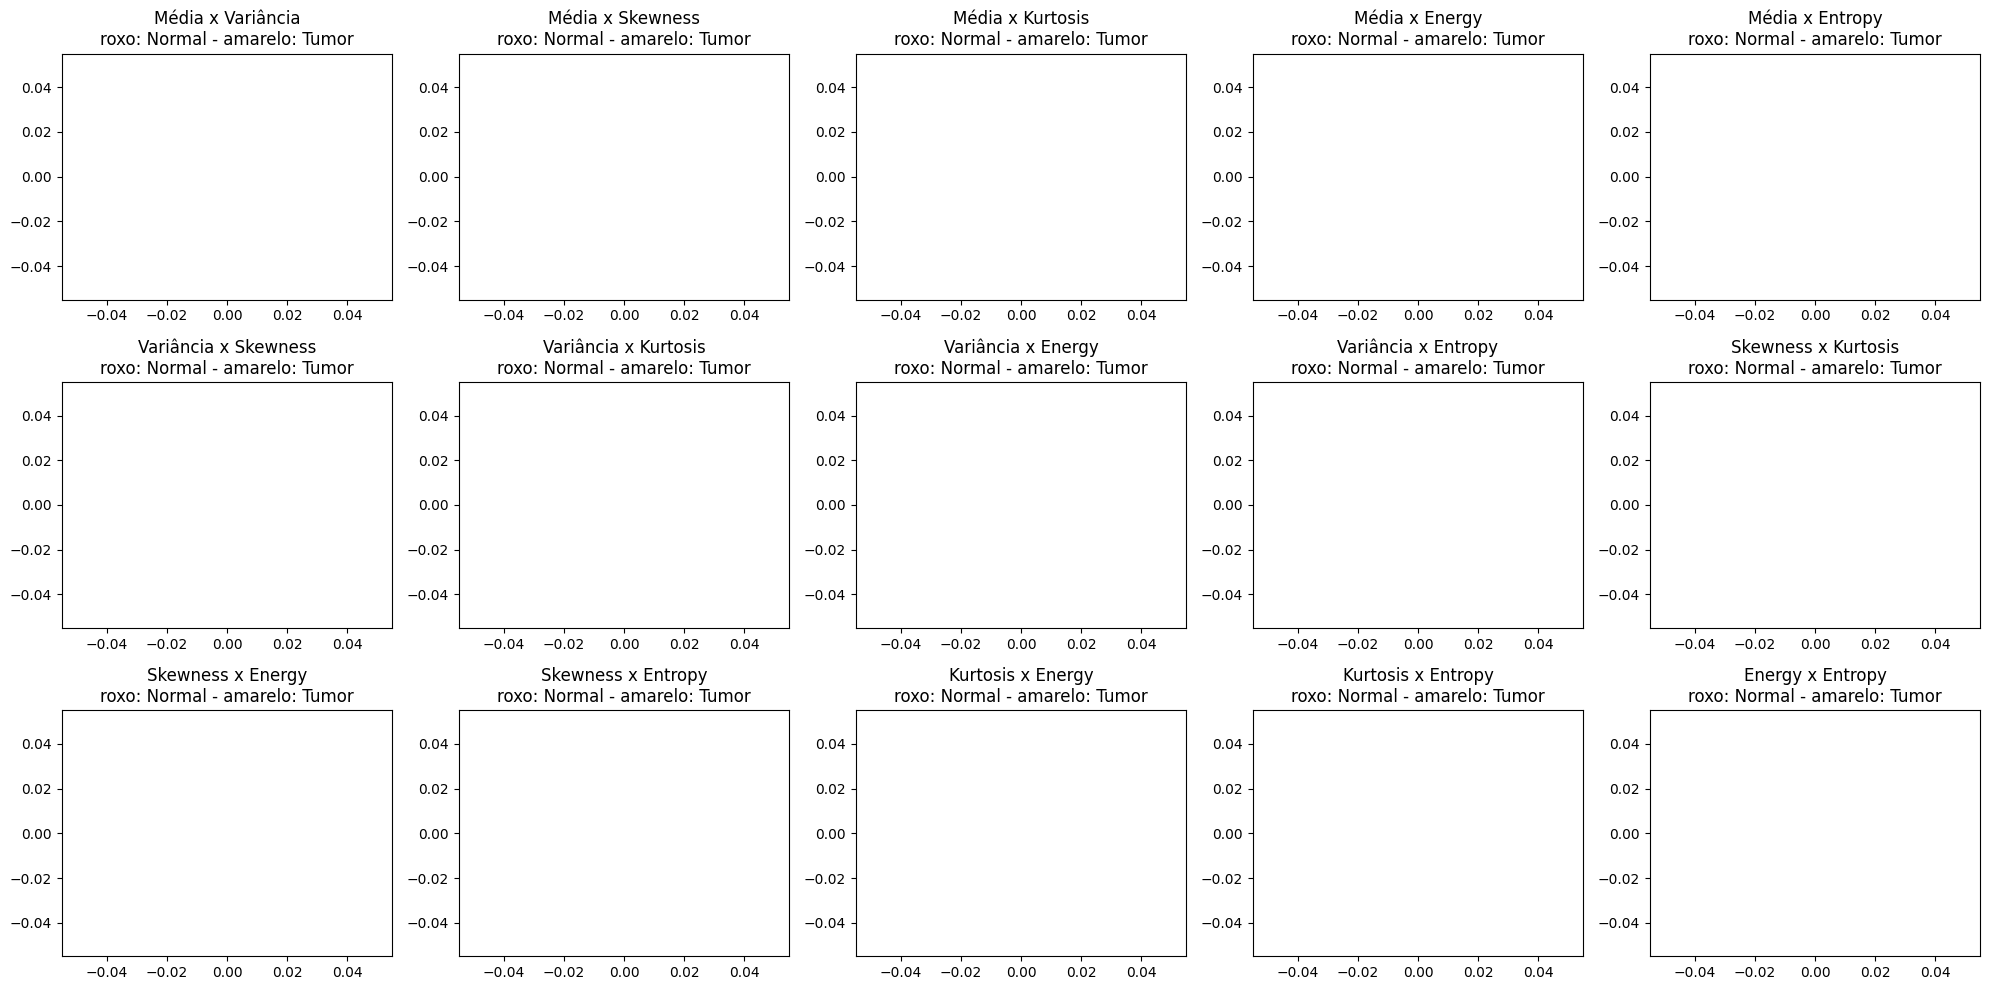

In [29]:
def histogram_features(image):    
    gray_image = rgb2gray(image)
    hist,_= histogram(gray_image)
    media = np.mean(hist) # Calcula a média do histograma, o que equivale à média das intensidades de cinza na imagem.
    var = np.var(hist) # Mede a dispersão das intensidades de cinza na imagem. Uma variância maior indica maior dispersão.
    sk = skew(hist) # A assimetria mede o grau de assimetria da distribuição das intensidades de cinza. Um valor positivo indica uma cauda longa à direita, enquanto um valor negativo indica uma cauda longa à esquerda.
    kur = kurtosis(hist, fisher=False) # A curtose mede a forma da distribuição das intensidades de cinza. O argumento "fisher=False" especifica que a kurtosis não será corrigida para o excesso (Fisher's kurtosis), o que é comum em estatísticas.
    entr = shannon_entropy(hist) # É uma medida de incerteza na distribuição das intensidades de cinza. Uma entropia maior indica maior incerteza.
    ener = np.sum(hist**2) # A energia é a soma dos quadrados dos valores no histograma e fornece uma ideia de quão concentradas ou dispersas estão as intensidades de cinza.
    
    return [media,var,sk,kur,ener,entr]


ntb = 'no_tumor' #diretórios com imagem de raio-x sem tumor
tb = 'glioma_tumor' #diretórios com imagem de raio-x com tumor
not_tumor = glob.glob(ntb + '*.jpg') 
tumor = glob.glob(tb + '*.jpg')

#Adiciona os atributos das imagens dos raio-x sem tumor e adiciona em um array 
features_not_tumor = []
for name in not_tumor:
    image = imread(name)
    features = histogram_features(image)
    features_not_tumor.append(features)
features_not_tumor = np.asarray(features_not_tumor) # Converte a lista "features_not_tumor" em uma matriz NumPy, onde cada linha da matriz contém as características de uma imagem sem tumor cerebral. 


#Adiciona os atributos das imagens dos raio-x com tumor e adiciona em um array
features_tumor = []
for name in tumor:
    image = imread(name)
    features = histogram_features(image)
    features_tumor.append(features)
features_tumor = np.asarray(features_tumor)

listaMedia = []
listaVar = []
listaSkew = []
listaKurtosis = []
listaEnergy = []
listaEntropy = []
labels = []

for i in features_not_tumor:
    listaMedia.append(i[0])
    listaVar.append(i[1])
    listaSkew.append(i[2])
    listaKurtosis.append(i[3])
    listaEnergy.append(i[4])
    listaEntropy.append(i[5])
    labels.append(0) # rótulo 0 à lista labels para indicar que a imagem não possui tumor cerebral.
    
for i in features_tumor:
    listaMedia.append(i[0])
    listaVar.append(i[1])
    listaSkew.append(i[2])
    listaKurtosis.append(i[3])
    listaEnergy.append(i[4])
    listaEntropy.append(i[5])
    labels.append(1) # rótulo 1 à lista labels para indicar que a imagem possui tumor cerebral.

tudo = []
nomes = ['Média', 'Variância', 'Skewness', 'Kurtosis', 'Energy', 'Entropy']
tudo.append(listaMedia)
tudo.append(listaVar)
tudo.append(listaSkew)
tudo.append(listaKurtosis)
tudo.append(listaEnergy)
tudo.append(listaEntropy)

plt.figure(figsize=(20, 10))
graph_order = 1 # controlar a ordem de exibição dos gráficos.
for i in range(len(tudo)):
    for j in range(i+1,len(tudo)):
        plt.subplot(3, 5, graph_order)
        plt.title(nomes[i] + " x " + nomes[j] + "\nroxo: Normal - amarelo: Tumor")
        plt.scatter(tudo[i], tudo[j], c=labels) # Os pontos no gráfico são coloridos com base nos rótulos contidos em labels. Os rótulos 0 representam imagens sem tumor, e os rótulos 1 representam imagens com tumor.
        graph_order += 1

plt.tight_layout()
#plt.savefig("scatter_not_equalized.png")
plt.show()


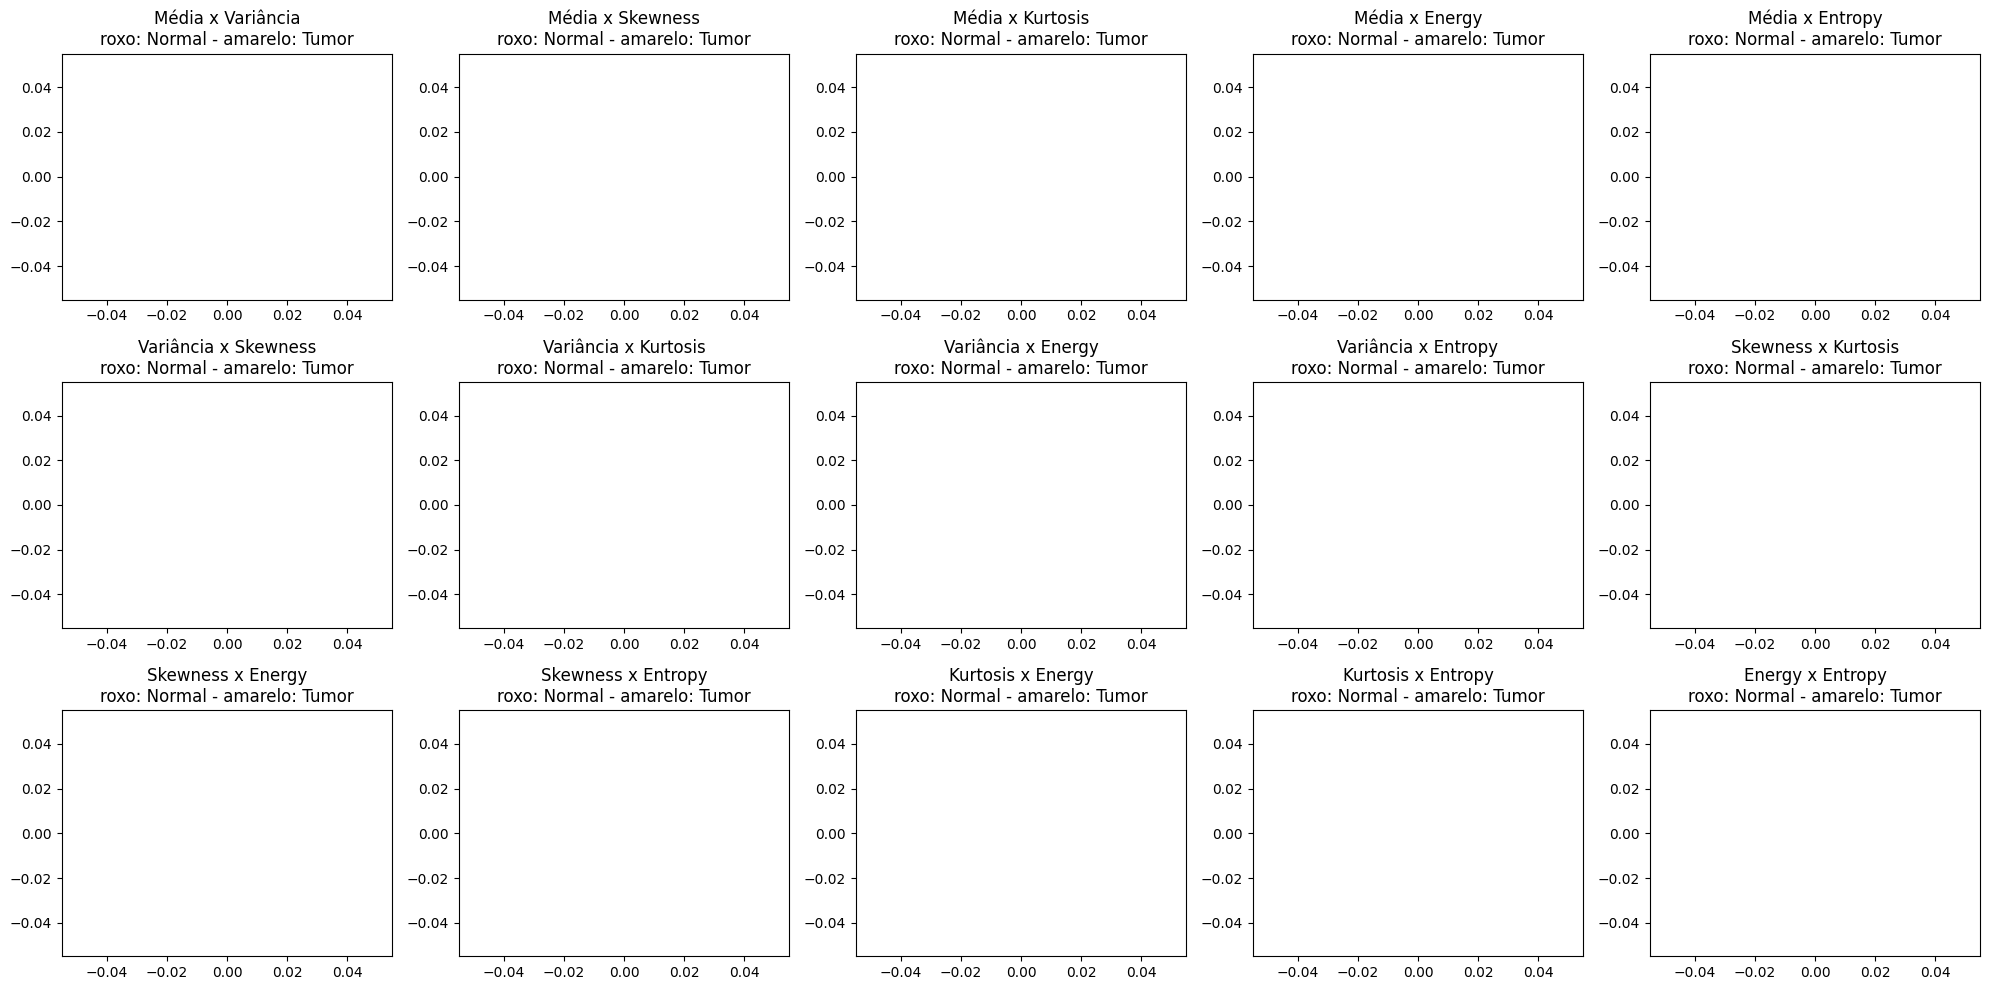

In [26]:
def histogram_features(image):    
    gray_image = equalize_hist(rgb2gray(image)) 
    # plt.hist(new_image.ravel()*255,bins=256);
    hist,_= histogram(gray_image)
    media = np.mean(hist)
    var = np.var(hist)
    sk = skew(hist)
    kur = kurtosis(hist, fisher=False)
    entr = shannon_entropy(hist)
    ener = np.sum(hist**2)
    
    return [media,var,sk,kur,ener,entr]


ntb = 'no_tumor' #diretórios com imagem de raio-x sem tumor
tb = 'glioma_tumor' #diretórios com imagem de raio-x com tumor
not_tumor = glob.glob(ntb + '*.jpg')
tumor = glob.glob(tb + '*.jpg')

#Adiciona os atributos das imagens das abelhas sem pólen e adiciona em um array 
features_not_tumor = []
for name in not_tumor:
    image = imread(name)
    features = histogram_features(image)
    features_not_tumor.append(features)
features_not_tumor = np.asarray(features_not_tumor)


#Adiciona os atributos das imagens das abelhas com pólen e adiciona em um array
features_tumor = []
for name in tumor:
    image = imread(name)
    features = histogram_features(image)
    features_tumor.append(features)
features_tumor = np.asarray(features_tumor)

listaMedia = []
listaVar = []
listaSkew = []
listaKurtosis = []
listaEnergy = []
listaEntropy = []
labels = []

for i in features_not_tumor:
    listaMedia.append(i[0])
    listaVar.append(i[1])
    listaSkew.append(i[2])
    listaKurtosis.append(i[3])
    listaEnergy.append(i[4])
    listaEntropy.append(i[5])
    labels.append(0)
    
for i in features_tumor:
    listaMedia.append(i[0])
    listaVar.append(i[1])
    listaSkew.append(i[2])
    listaKurtosis.append(i[3])
    listaEnergy.append(i[4])
    listaEntropy.append(i[5])
    labels.append(1)

tudo = []
nomes = ['Média', 'Variância', 'Skewness', 'Kurtosis', 'Energy', 'Entropy']
tudo.append(listaMedia)
tudo.append(listaVar)
tudo.append(listaSkew)
tudo.append(listaKurtosis)
tudo.append(listaEnergy)
tudo.append(listaEntropy)

plt.figure(figsize=(20, 10))
graph_order = 1
for i in range(len(tudo)):
    for j in range(i+1,len(tudo)):
        plt.subplot(3, 5, graph_order)
        plt.title(nomes[i] + " x " + nomes[j] + "\nroxo: Normal - amarelo: Tumor")
        plt.scatter(tudo[i], tudo[j], c=labels)
        graph_order += 1

plt.tight_layout()
#plt.savefig("scatter_not_equalized.png")
plt.show()


In [28]:
# Verificar se há imagens na pasta
if not tumor:
    print("Nenhuma imagem encontrada")
else:
    print("Encontradas {len(tumor_brain)} imagens em {pasta_imagems}")

# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.imshow(tumor[0], cmap='gray')
# plt.title('Imagem Original')

# plt.subplot(1, 2, 2)
# plt.imshow(not_tumor[0], cmap='gray')
# plt.title('Crescimento de Região com Level Set')

# plt.show()

Nenhuma imagem encontrada


In [38]:
# img = imread("images/training/T1_0001_D3.png")
# # gray_image = rgb2gray(img)
# # hist,_= histogram(gray_image)

# new_claro = equalize_hist(img)
# # plt.hist(new_claro.ravel()*255,bins=256);
# # plt.imshow(new_claro,cmap = "gray")
# plt.imshow(img,cmap = "gray")

In [34]:
ntb_tb = np.vstack((features_not_tumor,features_tumor)) # "np.vstack" Empilha verticalmente as matrizes de características "features_not_tumor" e "features_tumor".

from sklearn.preprocessing import StandardScaler # O "StandardScaler" é usado para padronizar (normalizar) os dados, fazendo com que eles tenham média zero e desvio padrão igual a um.
scaler = StandardScaler() # Cria uma instância do StandardScaler, que será usada para normalizar os dados.
scaler.fit(ntb_tb) # Isso calcula as médias e desvios padrão das características para que a normalização possa ser aplicada corretamente.
ntb_tb_norm = scaler.transform(ntb_tb) # Aplica a normalização aos dados

In [35]:
#rótulos da classe de cada imagem
ntb_class = [0] * 395  #241 imagens da classe sem tumor
tb_class = [1] * 826   ##258 imagens da classe com tumor

#Concatena os dois arrays
ntb_tb_class = ntb_class + tb_class

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.metrics import accuracy_score as acc

def classification(X,y):

    """
    X é uma matriz onde cada linha corresponde aos atributos calculados com o descritor
    y são os rótulos da classe de cada imagem. Exemplo [0,1,0,0,1,2,2,0,0,0,...,1]
    """
    
    # separar conjuntos de treino e teste
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7, random_state=40) # O parâmetro random_state é usado para garantir a reprodutibilidade dos resultados.
    # criar instancia do classificador
    clf = mlp(max_iter=200, random_state=40)
    # treinar o classificador
    clf.fit(X_train,y_train)
    # realizar a predicao
    pred = clf.predict(X_test)
    # calcular o resultado utilizando a acuracia
    acuracia = acc(y_test,pred)
    
    return acuracia

In [37]:
classification(ntb_tb_norm,ntb_tb_class)

# 0.9754768392370572 - não equalizado
# 0.9836512261580381 - equalizado

c:\Users\Lucas Santos\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.9836512261580381